In [ ]:
У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью из просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.
Команда ML сделала два алгоритма рекомендаций которые улучшают ленту:
1) Показываем пользователю посты, наиболее похожие на те, которые он лайкал. (группа 2)
2) Показываем пользователю посты, которые лайкали похожие на него пользователи.  (группа 3)
Ожидается, что новые алгоритмы сделают пользователей счастливее (то есть удлинится LTV, повысятся денежные 
конверсии и т.д.) а продукт удобнее/приятнее в использовании.
В дальнейшем мы будем тестировать эти алгоритмы АВ тестом. А пока поймем верно ли алгоритм хеширования разбил 
пользователей ленты на группы а также однородны ли они.
Для анализа возьмем метрику CTR -  в ней присутствуют лайки как индикатор заинтересованности, и она лишена 
недостатка просто абсолютного количества лайков, поскольку CTR  как бы нормирует лайки на просмотры и отражает
качественные изменения в заинтересованности
Для выяснения статистической однородности выборок, до АВ теста, проведем АА-тест, для дат
до внедрения нового алгоритма в ленту с '2024-12-27' по '2025-01-02'.
Для групп 2 и 3 берём из выборки, подвыборки без возвращения размером 500 
Сравниваем их t-тестом 10000 раз, и сохраняем p-value (используем аргумент equal_var=False)


In [ ]:
# Наши данные уже разбиты на группы с помощью алгоритма хеширования с "солью"
# К id пользователя прибавляет слово (соль - для каждого теста), затем алгоритм MD5 преобразует строку 
# в 128-битный хеш, (представленный в виде шестнадцатеричной строки) превращает это в уникальное число
# Берем остаток от деления числа на количетво групп - получаем группу (она будет всегда одна
# и таже для данного пользователя)
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [3]:
# Импорт необходимых библиотек для визаулизации, тестов, и сбора данных из ClickHouse
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandahouse as ph
import pandas as pd
# Подключение к ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}

# Запрос данных (пользователи уже разбиты на 4 экспериментальных группы)
# Группируем по пользователям и номеру группы, получим CRT у каждого пользователя
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
# Запрос исходной таблицы из БД для понимания структуры таблицы
q_table = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2024-12-27') and toDate(time) <= toDate('2025-01-02')"""

In [6]:
# Наша исходная таблица со всеми данными по каждому пользователю и группой exp_group
df_table = ph.read_clickhouse(q_table, connection=connection)
df_table.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,11509,1522,view,2024-12-27,1,14,Russia,Khabarovsk,Android,ads,2
1,14946,1121,view,2024-12-27,0,39,Russia,Kirov,iOS,ads,4
2,107626,1261,view,2024-12-27,1,19,Russia,Sibay,Android,organic,0
3,117693,1380,view,2024-12-27,1,19,Russia,Cherlak,Android,organic,2
4,119016,1467,view,2024-12-27,1,25,Russia,Kostroma,Android,organic,0


In [7]:
# Наш датафрейм c like, view, ctr для каждого пользователя
df = ph.read_clickhouse(q, connection=connection)
df.head(5)

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [8]:
# Сразу смотрим размер наших групп, должен быть примерно одинаков
df.groupby('exp_group')['user_id'].count()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

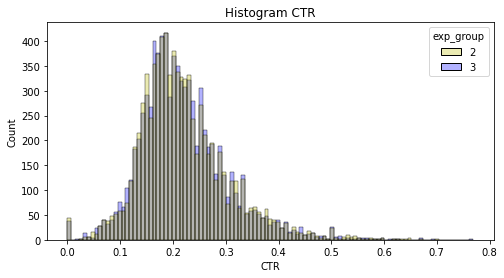

In [2]:
# Оценим наши выбоки визуально с помощью гистограммы
plt.figure(figsize=(8,4)) 
sns.histplot(data = df, x='ctr', hue='exp_group', palette = ['y', 'b'], alpha=0.3, kde=False)
plt.title('Histogram CTR')
plt.xlabel('CTR')
plt.ylabel('Count')
plt.show()
#  Визуально различий между нашими выборками нет

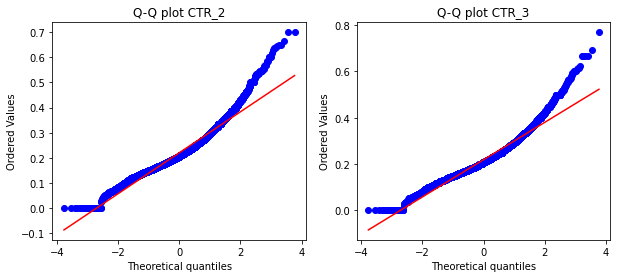

In [28]:
#  Q-Q plot для CTR_2
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
stats.probplot(df[df['exp_group'] == 2]['ctr'], dist="norm", plot=plt)
plt.title('Q-Q plot CTR_2')

#  Q-Q plot для CTR_3
plt.subplot(1, 2, 2)
stats.probplot(df[df['exp_group'] == 3]['ctr'], dist="norm", plot=plt)
plt.title('Q-Q plot CTR_3')
plt.show()
# Судя по графикам наши выборки имеют отличное от нормального распределение
# это выбросы в хвостах распределений, и небольшая ассиметрия.

In [3]:
# Посмотрим что датет проверка на нормальность теста Колмогорова-Смирнова
stat2, p2 = stats.kstest(df[df.exp_group == 2].ctr,'norm')
stat3, p3 = stats.kstest(df[df.exp_group == 3].ctr,'norm')
print(f'Для группы 2: Statistic = {stat2:.2f}, Pvalue = {p2:.2f}\n'
      f'Для группы 3: Statistic = {stat2:.2f}, Pvalue = {p2:.2f}')
# Нулевую гипотезу о нормальности распределения отклоняеем для обеих выборок

Для группы 2: Statistic = 0.51, Pvalue = 0.00
Для группы 3: Statistic = 0.51, Pvalue = 0.00


In [7]:
# Применяем тест Левена для проверки равенства дисперсий при отклонении от нормальности
stat, p_value = stats.levene(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)

print(f'Statistic levene = {stat:.2f} Pvalue = {p_value:.2f}')

# Похоже дисперсии наших распределений равны

Statistic levene = 0.32 Pvalue = 0.57


In [44]:
# Наши выборки имеют небольшие отклонения от нормального распределения, и равные дисперсии,
# при условии что размер выборок достаточно большой можно использовать T test.
# Для эксперимента посмотрим T-test и Mannwhitney
# Рекомендации по схожим постам - группа 2. 
# Рекомендации по похожим пользователям - группа 3

stat_t, p2_t = stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var=True) 
stat_mu, p2_mu = stats.mannwhitneyu(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)
print(f'T-test: Pvalue = {p2_t}\n'
      f'Mannwhitney: Pvalue = {p2_mu}')
# Оба теста говорят о однородности наших выборок

T-test: Pvalue = 0.5081292746071069
Mannwhitney: Pvalue = 0.8340910379715747


In [58]:
# Проведем Т-тест 10 000 раз со случайными подвыборками по 500 человек из групп 2 и 3
# Без возвращения replace=False для чистоты эксперимента
p_distribution = []
p_low = 0
for _ in range(10000):
    p = stats.ttest_ind(
    df[df.exp_group == 2].ctr.sample(500, replace=False),
    df[df.exp_group == 3].ctr.sample(500, replace=False),
    equal_var=True).pvalue
    p_distribution.append(p)
    if p < 0.05:
        p_low += 1
print(f'Доля p_value ниже 0,05 = {p_low/len(p_distribution)}')          

Доля p_value ниже 0,05 = 0.0475


In [59]:
# Доля ложных срабатываний T-test составляет менее 5% что полностью согласуется 
# с нулевой гипотезой о равенстве средних CTR в выборках. Как итог можно сказать что
# наш АА тест подтверждает гипотезу о статистической однородности выборок до применения
# нового алгоритма в ленте

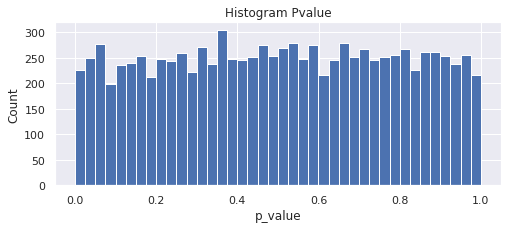

In [66]:
# Посмотрим гистограмму распределения  p-value (Т-тест 10 000 раз подвыборки по 500 человек из групп 2 и 3)
p_data = pd.DataFrame(p_distribution, columns=['p_value'])

plt.figure(figsize=(8,3))
plt.hist(p_data['p_value'], bins=40)
plt.title('Histogram Pvalue')
plt.xlabel('p_value')
plt.ylabel('Count')
plt.show()   
# Распределение получилось равномерное, что говорить об отсутствии
# различий между выборками